## Settings and Pointers

In [2]:
service_account_path = "creds/google__sa.json"
tracking_sheet_id = "1qBU7Kvuuij2fxbqPxebReKMxWgIBmOIE5Gi4ZuX0j_4"

In [6]:
import pandas as pd

from src.sheets_utils import download_sheet_as_df


contributors_df = download_sheet_as_df(
    service_account_path,
    tracking_sheet_id,
    "Contributors"
)

df = pd.concat(
    [
        download_sheet_as_df(
            service_account_path,
            tracking_sheet_id,
            "Conversations_Batch_2"
        ),
        download_sheet_as_df(
            service_account_path,
            tracking_sheet_id,
            "Conversations_Batch_3"
        ),
        download_sheet_as_df(
            service_account_path,
            tracking_sheet_id,
            "Conversations_Batch_4"
        ),
        download_sheet_as_df(
            service_account_path,
            tracking_sheet_id,
            "Conversations_Batch_5"
        ),
    ],
    ignore_index=True
)

df = df[df["completion_status"] == "Done"].reset_index()
df

## Calculate number of turns

In [ ]:
# Parse Conversations into list of dicts

import io
import threading

import nbformat
from fuzzywuzzy import fuzz

from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload


def get_closest_match(query, choices):
    """
    Get the closest match(es) to a query string from a list of choices.

    :param query: The query string.
    :param choices: A list of strings to match against.
    :param limit: The maximum number of matches to return.
    """
    best_role = None
    best_score = 0
    for choice in choices:
        score = fuzz.ratio(query, choice)
        if score > best_score and score > 25:
            best_score = score
            best_role = choice

    return best_role, best_score


def notebook_parser(notebook):
    """
    Parse a notebook and extract the message objects.

    :param notebook: The notebook object.
    """
    messages = []
    for cell in notebook.cells[2:]:
        if cell["cell_type"] == "markdown":
            markdown_headers = ["**User**", "**Assistant**"]
            lines = cell["source"].split("\n")
            first_line = lines[0]
            role, score = get_closest_match(first_line, markdown_headers)
            if score>25:
                message = {
                    "role": role.replace("*", "").strip(),
                    "content": "\n".join(lines[1:]).strip("\n"),
                    "type": "markdown"
                }
                messages.append(message)

        elif cell["cell_type"] == "code":
            code_headers = ["# User", "# Assistant"]
            lines = cell["source"].split("\n")
            first_line = lines[0]
            role, score = get_closest_match(first_line, code_headers)
            if score>25:
                message = {
                    "role": role.replace("#", "").strip(),
                    "content": "\n".join(lines[1:]).strip("\n"),
                    "type": "code"
                }
                messages.append(message)
    return messages


def download_and_parse_notebook(service_account_file, file_id):
    # Authenticate with the service account
    credentials = service_account.Credentials.from_service_account_file(
        service_account_file, scopes=['https://www.googleapis.com/auth/drive'])
    service = build('drive', 'v3', credentials=credentials)

    # Request to download the file
    request = service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    # Download the file
    done = False
    while not done:
        status, done = downloader.next_chunk()
        print("Download progress: %d%%." % int(status.progress() * 100))

    # Move the buffer's pointer to the beginning
    fh.seek(0)

    # Open the notebook
    notebook = nbformat.read(fh, as_version=4)

    # Parse the notebook
    messages = notebook_parser(notebook)

    # # Extract the first cell
    first_cell = notebook.cells[0]
    lines = first_cell["source"].split("\n")
    metadata = {}
    for line in lines:
        if "**Python Topics**" in line:
            metadata["topic"] = line.split(" - ")[1]
        if "**Type**" in line:
            metadata["type"] = line.split(" - ")[1]
        if "**Target Number of Turns (User + Assistant)**" in line:
            metadata["target_turns"] = line.split(" - ")[1]

    return {
        "id": file_id,
        "metadata": metadata,
        "messages":messages
    }


def threading_processor(service_account_path, file_id, results):
    results.append(download_and_parse_notebook(service_account_path, file_id))


threads = []
parsed_conversations = []
for i in range(df.shape[0]):
    file_id = df["task_link"][i].split("/")[-1]
    thread = threading.Thread(target=threading_processor, args=(service_account_path, file_id, parsed_conversations))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()


## Visualize distribution of dataset
- Top Level Topic
- Number of Turns
- Internal vs Anthropic vs Dedicated
- Daily Trends by Team
- Daily Trends by Turns

In [7]:
from datetime import datetime

def get_number_of_turns(messages):

    initial_role = messages[0]["role"]

    count = 0
    for message in messages:
        if message["role"] == initial_role:
            count += 1
    return count


def standardize_date_format(date):
    """
    Given a date string, standardize the date format to YYYY/MM/DD.
    """
    if date is None:
        return ""
    try:
        # Parse the date string into a datetime object
        standardized_date = datetime.strptime(date, "%Y/%m/%d")
    except ValueError:
        try:
            # Attempt to parse other common formats here
            # Example: MM/DD/YYYY
            standardized_date = datetime.strptime(date, "%m/%d/%Y")
        except ValueError:
            return "Invalid date format"

    # Format the datetime object into the desired string format
    return standardized_date.strftime("%Y/%m/%d")


metadata_only = []
for conversation in parsed_conversations:
    
    # Extract actual number of turns
    conversation["metadata"]["actual_turns"] = get_number_of_turns(conversation["messages"])

    try:
        tracking_record = df[df["task_link"].str.contains(conversation["id"])].iloc[0].to_dict()
    except IndexError:
        print("IndexError for id:", conversation["id"])
        continue

    # Get Author email
    conversation["metadata"]["assigned_to_email"] = tracking_record["assigned_to_email"]

    # Get duration
    conversation["metadata"]["duration_mins"] = tracking_record["duration_mins"]

    # Get Completion Date
    conversation["metadata"]["completion_date"] = standardize_date_format(tracking_record["completion_date"])

    # Get Team
    try:
        conversation["metadata"]["team"] = contributors_df[contributors_df["Email"] == tracking_record["assigned_to_email"]].iloc[0]["Source"]
    except IndexError:
        print("IndexError for email:", tracking_record["assigned_to_email"])
        conversation["metadata"]["team"] = "Unknown"

    metadata_only.append(conversation["metadata"])

IndexError for email: satya.s@turing.com
IndexError for email: https://colab.research.google.com/drive/1s6QrFchojtSInYl0xrwJ-Dcv6gqqL8lB
IndexError for email: satya.s@turing.com
IndexError for email: 
IndexError for email: 
IndexError for email: jha.r@turring.com


In [8]:
metadata_only_df = pd.DataFrame(metadata_only)
metadata_only_df

,topic,type,target_turns,actual_turns,assigned_to_email,duration_mins,completion_date,team
0,unit_testing_methodology > test_driven_develop...,query,1,1,ruturaj.m@turing.com,15,2023/12/21,Anthropic
1,python_language_and_scripting > decorators,query,1,1,ruturaj.m@turing.com,10,2023/12/21,Anthropic
2,algorithms > by_topic > geometry,modification,1,1,james.oladimeji-c@turing.com,15,2023/12/20,Cross Clients
3,python_language_and_scripting > dynamic_progra...,modification,1,1,lucas.k@turing.com,15,2023/12/21,Anthropic
4,algorithms > by_topic > math,modification,1,1,lucas.k@turing.com,12,2023/12/21,Anthropic
...,...,...,...,...,...,...,...,...
1352,python_language_and_scripting > context_managers,modification,2+,2,zubair.m@turing.com,20,2024/01/01,Vetting
1353,algorithms > by_data_structure > queues,query,2+,2,ritesh.r@turing.com,30,2023/12/29,Anthropic
1354,unit_testing_methodology > test_driven_develop...,modification,2,2,zain.v@turing.com,25,2023/12/26,Vetting
1355,unit_testing_methodology > testing_database_in...,query,2+,2,caram.v@turing.com,30,2024/01/01,Vetting


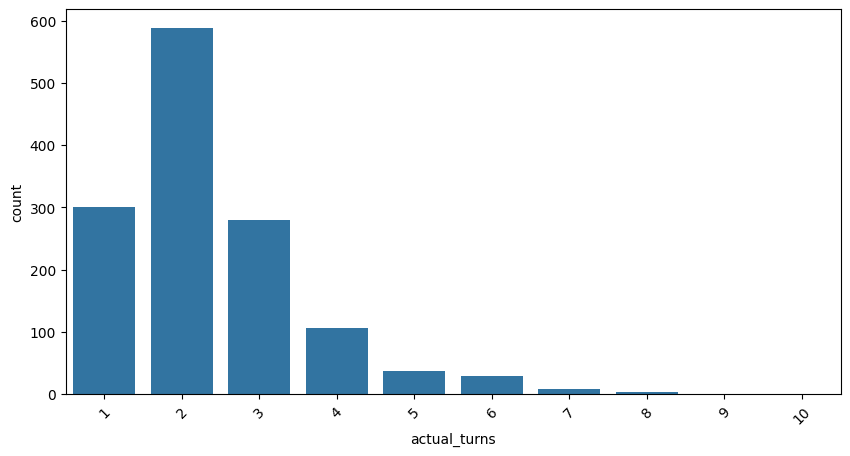

In [9]:
# Visualize Convo Length
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="actual_turns")
plt.xticks(rotation=45)
plt.show()



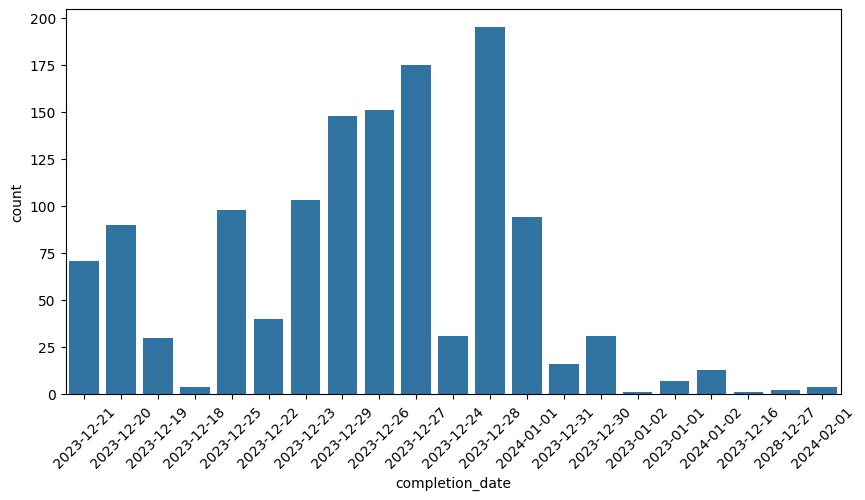

In [14]:
# Visualize Trend over time
plt.figure(figsize=(10, 5))
metadata_only_df["completion_date"] = metadata_only_df["completion_date"].replace("Invalid date format", "")
metadata_only_df["completion_date"] = pd.to_datetime(metadata_only_df["completion_date"], format="mixed")
sns.countplot(data=metadata_only_df, x="completion_date")
plt.xticks(rotation=45)
plt.show()

- Top Level Topic
- Number of Turns
- Internal vs Anthropic vs Dedicated
- Daily Trends by Team
- Daily Trends by Turns

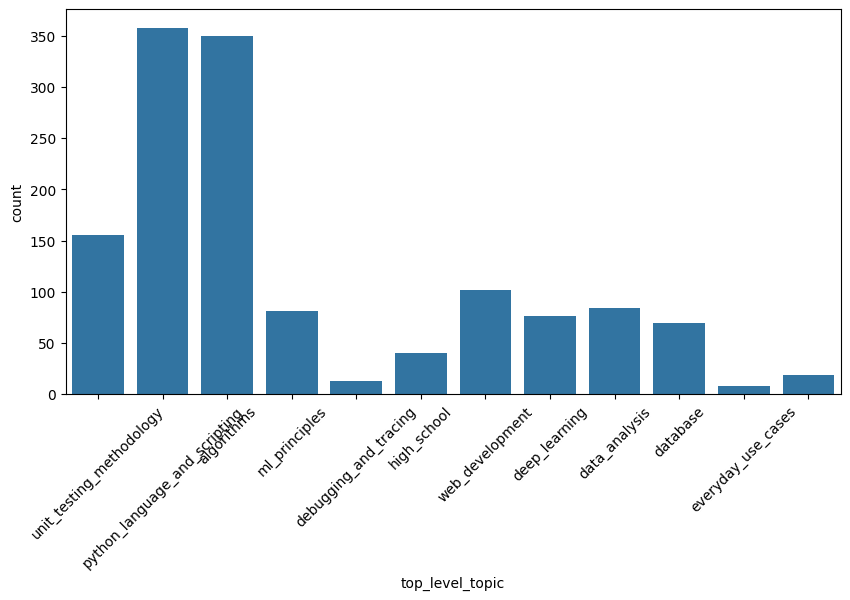

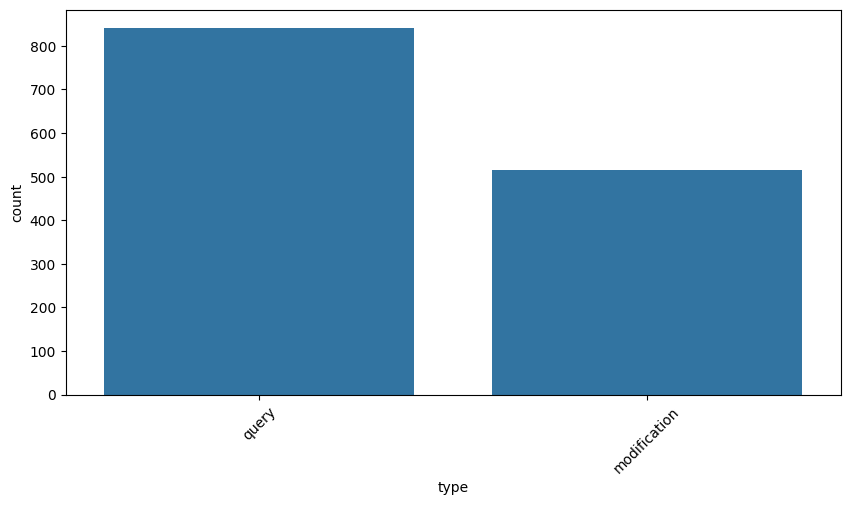

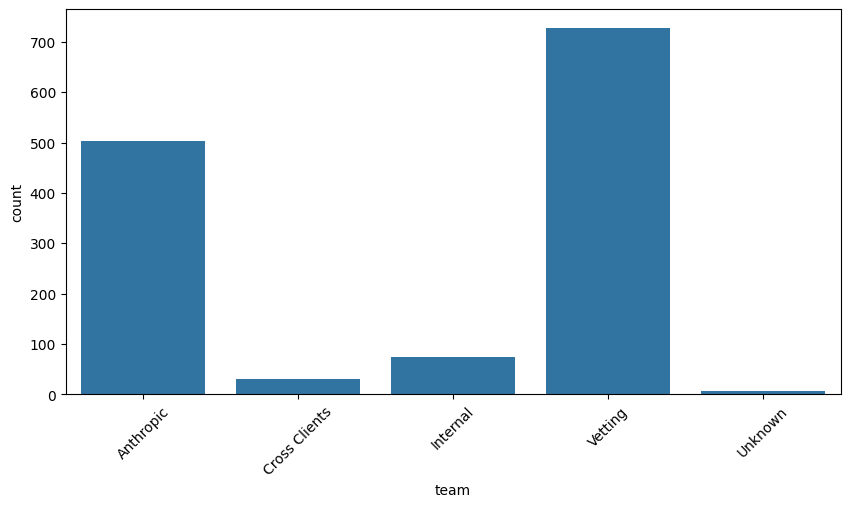

In [16]:
metadata_only_df["top_level_topic"] = metadata_only_df["topic"].fillna("").apply(lambda x: x.split(" > ")[0])
plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="top_level_topic")
plt.xticks(rotation=45)

plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="type")
plt.xticks(rotation=45)

plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="team")
plt.xticks(rotation=45)

plt.show()

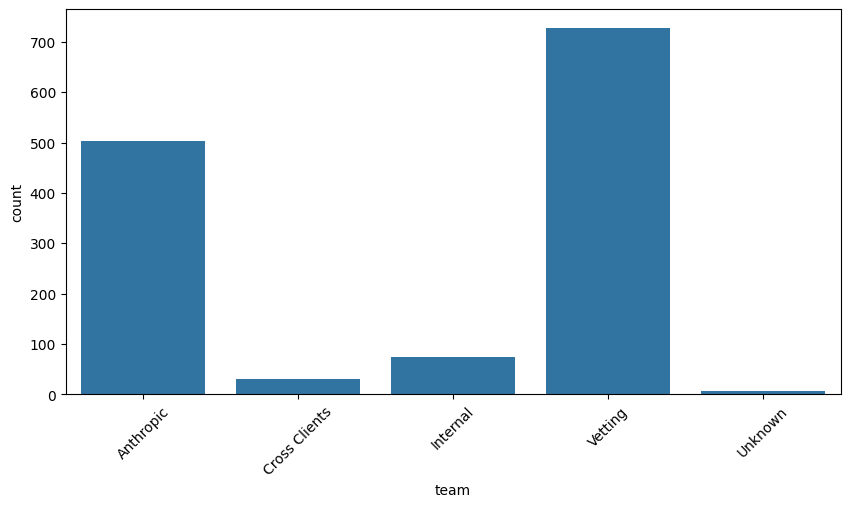

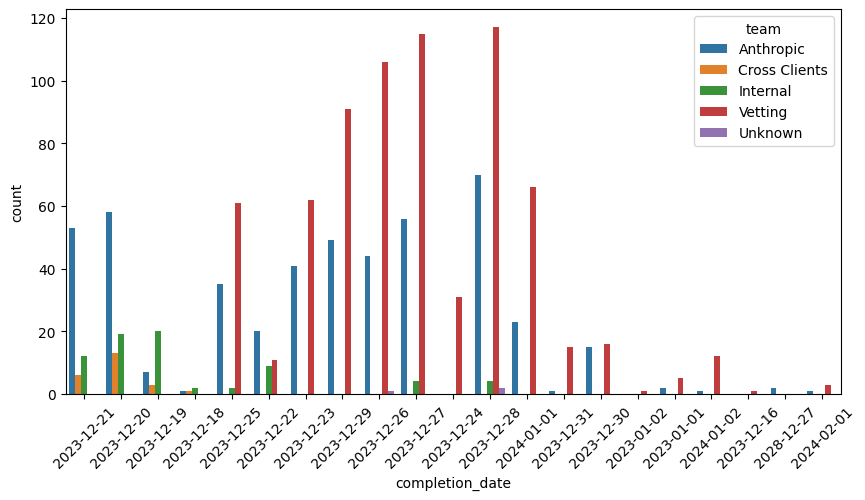

In [17]:
# Breakdown by team (2 subplots; 1 for totals, 1 for trendline by completion_date)
plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="team")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="completion_date", hue="team")
plt.xticks(rotation=45)
plt.show()

## Analyze avg time by trainer (Vetting)

In [18]:
# Process the duration_mins column to make into int

def process_duration_mins(duration_mins):
    if duration_mins == "" or duration_mins is None:
        return 15
    elif isinstance(duration_mins, int):
        return duration_mins
    else:
        return int(duration_mins.split(" ")[0])
    
metadata_only_df["duration_mins"] = metadata_only_df["duration_mins"].apply(process_duration_mins)

trainer_avg_duration = metadata_only_df[metadata_only_df["team"]=="Vetting"].groupby("assigned_to_email").agg({"duration_mins": "mean"}).reset_index()
trainer_avg_duration = trainer_avg_duration.sort_values("duration_mins", ascending=True)
trainer_avg_duration

,assigned_to_email,duration_mins
26,prateek.j@turing.com,22.848485
16,jha.r@turing.com,24.909091
17,joseph.d@turing.com,26.666667
24,paulo.c@turing.com,28.022222
9,caram.v@turing.com,29.878788
32,zubair.m@turing.com,30.000000
31,zain.v@turing.com,32.021739
12,elsadek.a@turing.com,33.090909
8,armas.j@turing.com,33.478261
7,archit.k@turing.com,33.548387


## Average turns per trainer

In [19]:
trainer_avg_turn_count = metadata_only_df[metadata_only_df["team"]=="Vetting"].groupby("assigned_to_email").agg({"actual_turns": "mean", "topic": "count"}).reset_index()
trainer_avg_turn_count = trainer_avg_turn_count.rename(columns={"topic": "total_conversations"})
trainer_avg_turn_count = trainer_avg_turn_count.sort_values("actual_turns", ascending=False)
trainer_avg_turn_count

,assigned_to_email,actual_turns,total_conversations
14,gedeon.a@turing.com,5.925000,40
19,kishore.g@turing.com,5.000000,29
28,safi.u@turing.com,3.717391,46
11,daniel.i@turing.com,3.500000,2
12,elsadek.a@turing.com,3.363636,44
2,abdullah.i@turing.com,3.361702,47
16,jha.r@turing.com,3.272727,10
6,andranik.g@turing.com,3.142857,7
8,armas.j@turing.com,3.086957,19
22,marcus.a@turing.com,3.086957,22


## Average time per turn by trainer

In [20]:
trainer_avg_turn_duration = metadata_only_df[metadata_only_df["team"]=="Vetting"].groupby("assigned_to_email").agg({"duration_mins": "mean", "actual_turns": "mean"}).reset_index()
trainer_avg_turn_duration["avg_turn_duration"] = trainer_avg_turn_duration["duration_mins"] / trainer_avg_turn_duration["actual_turns"]
trainer_avg_turn_duration = trainer_avg_turn_duration.sort_values("avg_turn_duration", ascending=True)
trainer_avg_turn_duration

,assigned_to_email,duration_mins,actual_turns,avg_turn_duration
14,gedeon.a@turing.com,36.875000,5.925000,6.223629
16,jha.r@turing.com,24.909091,3.272727,7.611111
26,prateek.j@turing.com,22.848485,2.333333,9.792208
12,elsadek.a@turing.com,33.090909,3.363636,9.837838
28,safi.u@turing.com,38.630435,3.717391,10.391813
8,armas.j@turing.com,33.478261,3.086957,10.845070
31,zain.v@turing.com,32.021739,2.891304,11.075188
24,paulo.c@turing.com,28.022222,2.444444,11.463636
6,andranik.g@turing.com,37.857143,3.142857,12.045455
29,singh.r@turing.com,34.090909,2.818182,12.096774


## Analyze avg quality per trainer

In [21]:
reviews_df = download_sheet_as_df(
    service_account_path,
    tracking_sheet_id,
    "Reviews"
)

reviews = reviews_df[reviews_df["Author Email"].isin(trainer_avg_turn_duration["assigned_to_email"].tolist())]
reviews = reviews.astype({"Code Quality": "int32", "Language Quality": "int32"})
reviews["avg_quality_score"] = (reviews["Code Quality"] + reviews["Language Quality"]) / 2

trainer_avg_quality = reviews.groupby("Author Email").agg({"avg_quality_score": "mean", "Timestamp":"count"}).reset_index()
trainer_avg_quality = trainer_avg_quality.rename(columns={"Timestamp": "total_reviews"})
trainer_avg_quality = trainer_avg_quality.sort_values("avg_quality_score", ascending=False)
trainer_avg_quality

,Author Email,avg_quality_score,total_reviews
6,andranik.g@turing.com,5.000000,2
15,jha.r@turing.com,4.900000,5
23,paulo.c@turing.com,4.875000,4
12,freitas.g@turing.com,4.875000,4
31,zubair.m@turing.com,4.833333,3
18,kishore.g@turing.com,4.833333,3
14,ishwar.b@turing.com,4.800000,5
17,khalid.s@turing.com,4.750000,4
8,armas.j@turing.com,4.750000,2
21,marcus.a@turing.com,4.700000,5


## Analyze total throughput per trainer

In [22]:
# Count of tasks per trainer
trainer_throughput = metadata_only_df[metadata_only_df["team"]=="Vetting"].groupby("assigned_to_email").agg({"topic": "count", "duration_mins":"sum", "actual_turns":"sum"}).reset_index()
trainer_throughput = trainer_throughput.sort_values("topic", ascending=False)
trainer_throughput[trainer_throughput["duration_mins"]>=500].sort_values("duration_mins", ascending=False)

,assigned_to_email,topic,duration_mins,actual_turns
2,abdullah.i@turing.com,47,2612,158
19,kishore.g@turing.com,29,2050,145
3,adil.m@turing.com,42,2040,100
28,safi.u@turing.com,46,1777,171
13,freitas.g@turing.com,42,1615,105
14,gedeon.a@turing.com,40,1475,237
31,zain.v@turing.com,46,1473,133
12,elsadek.a@turing.com,44,1456,148
24,paulo.c@turing.com,45,1261,110
7,archit.k@turing.com,31,1040,81


In [24]:
trainer_throughput[trainer_throughput["duration_mins"]<500].sort_values("duration_mins", ascending=False)

,assigned_to_email,topic,duration_mins,actual_turns
8,ishwar.b@turing.com,13,445,31
3,armas.j@turing.com,12,415,39
17,sudharchith.s@turing.com,9,320,18
15,rohit.kumar@turing.com,6,270,12
10,kumbar.r@turing.com,3,160,9


## Analyze diversity per trainer

In [38]:
def extract_top_level_topic(topic):
    return topic.split(" > ")[0]

metadata_only_df["top_level_topic"] = metadata_only_df["topic"].apply(extract_top_level_topic)

# Aggregation of Count of tasks per trainer per top level topic in a new variable trainer_diversity
trainer_diversity = metadata_only_df[metadata_only_df["team"]=="Vetting"].groupby(["assigned_to_email", "top_level_topic"]).agg({"topic": "count"}).reset_index()
trainer_diversity = trainer_diversity.rename(columns={"topic": "count"})
trainer_diversity = trainer_diversity.sort_values("count", ascending=False)
trainer_diversity

,assigned_to_email,top_level_topic,count
0,abdullah.i@turing.com,algorithms,14
90,safi.u@turing.com,deep_learning,14
105,zain.v@turing.com,web_development,13
54,kishore.g@turing.com,deep_learning,11
4,abdullah.i@turing.com,python_language_and_scripting,11
...,...,...,...
41,gedeon.a@turing.com,database,1
33,freitas.g@turing.com,database,1
32,freitas.g@turing.com,data_analysis,1
63,marcel.s@turing.com,unit_testing_methodology,1


In [39]:
trainer_diversity[trainer_diversity["top_level_topic"]=="algorithms"]

,assigned_to_email,top_level_topic,count
0,abdullah.i@turing.com,algorithms,14
6,adil.m@turing.com,algorithms,10
99,zain.v@turing.com,algorithms,10
31,freitas.g@turing.com,algorithms,9
26,elsadek.a@turing.com,algorithms,8
13,archit.k@turing.com,algorithms,7
65,marcus.a@turing.com,algorithms,5
86,rohit.kumar@turing.com,algorithms,4
52,kishore.g@turing.com,algorithms,3
59,marcel.s@turing.com,algorithms,3


In [40]:
trainer_diversity[trainer_diversity["top_level_topic"]=="unit_testing_methodology"]

,assigned_to_email,top_level_topic,count
104,zain.v@turing.com,unit_testing_methodology,6
45,gedeon.a@turing.com,unit_testing_methodology,6
38,freitas.g@turing.com,unit_testing_methodology,5
24,caram.v@turing.com,unit_testing_methodology,5
69,marcus.a@turing.com,unit_testing_methodology,3
11,adil.m@turing.com,unit_testing_methodology,2
50,ishwar.b@turing.com,unit_testing_methodology,2
5,abdullah.i@turing.com,unit_testing_methodology,2
94,safi.u@turing.com,unit_testing_methodology,1
84,prateek.j@turing.com,unit_testing_methodology,1


In [41]:
trainer_diversity[trainer_diversity["top_level_topic"].isin(["ml_principles", "data_analysis", "deep_learning"])].groupby("assigned_to_email").agg({"count": "sum"}).reset_index().sort_values("count", ascending=False)

,assigned_to_email,count
11,safi.u@turing.com,29
6,kishore.g@turing.com,22
2,archit.k@turing.com,7
5,gedeon.a@turing.com,6
3,elsadek.a@turing.com,5
4,freitas.g@turing.com,5
0,abdullah.i@turing.com,3
9,paulo.c@turing.com,3
1,adil.m@turing.com,2
10,prateek.j@turing.com,2


In [42]:
trainer_diversity[trainer_diversity["top_level_topic"].isin(["web_development", "database"])].groupby("assigned_to_email").agg({"count": "sum"}).reset_index().sort_values("count", ascending=False)


,assigned_to_email,count
15,zain.v@turing.com,17
11,paulo.c@turing.com,13
12,prateek.j@turing.com,11
0,adil.m@turing.com,7
7,ishwar.b@turing.com,6
3,caram.v@turing.com,5
5,freitas.g@turing.com,4
10,marcus.a@turing.com,4
2,armas.j@turing.com,3
8,kumbar.r@turing.com,3


In [43]:
# Calculate the unique number of topics per trainer
trainer_unique_topics = trainer_diversity.groupby("assigned_to_email").agg({"top_level_topic": "count"}).reset_index()
trainer_unique_topics = trainer_unique_topics.rename(columns={"top_level_topic": "unique_topics"})
trainer_unique_topics = trainer_unique_topics.sort_values("unique_topics", ascending=False)
trainer_unique_topics

,assigned_to_email,unique_topics
6,freitas.g@turing.com,9
16,safi.u@turing.com,8
13,paulo.c@turing.com,8
18,zain.v@turing.com,7
1,adil.m@turing.com,7
14,prateek.j@turing.com,7
12,marcus.a@turing.com,6
11,marcel.s@turing.com,6
0,abdullah.i@turing.com,6
8,ishwar.b@turing.com,6


In [45]:
import numpy as np


def calculate_diversity(df, group_by="assigned_to_email", count_column="count", entropy_column="entropy"):
    """
    Calculate the diversity of a dataframe.

    :param df: The dataframe to calculate diversity on.
    :param group_by: The column to group by.
    :param count_column: The column to count.
    :param entropy_column: The column to store the entropy in.
    """
    # Step 1: Normalize counts
    total_counts = df.groupby(group_by)[count_column].transform('sum')
    df['normalized_count'] = df[count_column] / total_counts

    # Step 2: Calculate entropy
    df['entropy_component'] = -df['normalized_count'] * np.log2(df['normalized_count'])
    entropy = df.groupby(group_by)['entropy_component'].sum().reset_index()

    entropy.columns = [group_by, entropy_column]
    return entropy


topleveltopic_diversity = calculate_diversity(trainer_diversity)
topleveltopic_diversity = topleveltopic_diversity.sort_values("entropy", ascending=False)
topleveltopic_diversity

,assigned_to_email,entropy
6,freitas.g@turing.com,2.797059
18,zain.v@turing.com,2.542510
14,prateek.j@turing.com,2.467727
13,paulo.c@turing.com,2.454097
12,marcus.a@turing.com,2.382856
1,adil.m@turing.com,2.374694
8,ishwar.b@turing.com,2.345852
16,safi.u@turing.com,2.290938
11,marcel.s@turing.com,2.254448
7,gedeon.a@turing.com,2.226121


In [46]:
trainer_diversity[trainer_diversity["assigned_to_email"]=="kishore.g@turing.com"]

,assigned_to_email,top_level_topic,count,normalized_count,entropy_component
54,kishore.g@turing.com,deep_learning,11,0.407407,0.527778
55,kishore.g@turing.com,ml_principles,9,0.333333,0.528321
52,kishore.g@turing.com,algorithms,3,0.111111,0.352214
53,kishore.g@turing.com,data_analysis,2,0.074074,0.278140
57,kishore.g@turing.com,unit_testing_methodology,1,0.037037,0.176107
56,kishore.g@turing.com,python_language_and_scripting,1,0.037037,0.176107


In [49]:
trainer_diversity[trainer_diversity["assigned_to_email"]=="safi.u@turing.com"]

,assigned_to_email,top_level_topic,count,normalized_count,entropy_component
90,safi.u@turing.com,deep_learning,14,0.400000,0.528771
92,safi.u@turing.com,ml_principles,9,0.257143,0.503835
88,safi.u@turing.com,data_analysis,6,0.171429,0.436169
93,safi.u@turing.com,python_language_and_scripting,2,0.057143,0.235959
91,safi.u@turing.com,high_school,1,0.028571,0.146551
89,safi.u@turing.com,database,1,0.028571,0.146551
94,safi.u@turing.com,unit_testing_methodology,1,0.028571,0.146551
95,safi.u@turing.com,web_development,1,0.028571,0.146551


In [50]:
trainer_diversity[trainer_diversity["assigned_to_email"]=="freitas.g@turing.com"]

,assigned_to_email,top_level_topic,count,normalized_count,entropy_component
37,freitas.g@turing.com,python_language_and_scripting,9,0.250000,0.500000
31,freitas.g@turing.com,algorithms,9,0.250000,0.500000
38,freitas.g@turing.com,unit_testing_methodology,5,0.138889,0.395555
35,freitas.g@turing.com,high_school,4,0.111111,0.352214
39,freitas.g@turing.com,web_development,3,0.083333,0.298747
34,freitas.g@turing.com,deep_learning,2,0.055556,0.231663
36,freitas.g@turing.com,ml_principles,2,0.055556,0.231663
33,freitas.g@turing.com,database,1,0.027778,0.143609
32,freitas.g@turing.com,data_analysis,1,0.027778,0.143609
